# Figure 2: SNPs comparison to known sites of phenotypic importance

June 6, 2019

I would like to see whether any of the SNVs we find within-host occur at codon sites that are linked to functional change. To assess this, I used the [Influenza Research Database Sequence Feature Variant Types tool](https://www.fludb.org/brc/influenza_sequenceFeatureVariantTypes_search.spg?method=ShowCleanSearch&decorator=influenza) to download all functional and sequence alteration annotations for each gene. I queried all H5 HA annotations, all N1 NA annotations, and all available annotations for all subtypes for the internal genes. 

In this notebook, I parse that data and use it to annotate my SNV calls. 

In [1]:
import re
import numpy as np
import pandas as pd
import rpy2
from scipy import stats

%load_ext rpy2.ipython 

In [2]:
directory = "/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/comparison-to-known-sites/"
SNP_calls = "/Users/lmoncla/src/h5n1-cambodia/data/within-host-variants-1%.txt"
flugenes = ["PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"]
genes = []
for f in flugenes: 
    gene_file = directory + f + "-known-functional-alteration-sites.tsv"
    genes.append(gene_file)

In [3]:
# write a little function to remove all of the HA1 and HA2 annotations in parantheses using iterative grep 

def remove_HA_annotation(amino_acid_position):
    amino_acid_position = amino_acid_position.replace("\"","")
    amino_acid_position = amino_acid_position.replace("\"","")
    
    searchstr = '(\\([A-z0-9\ ]+\\))'
    for match in re.finditer(searchstr,amino_acid_position):
        amino_acid_position = amino_acid_position.replace(match.groups()[0],"")
        
    return(amino_acid_position)

In [4]:
annotations = {"PB2":{},"PB1":{},"PA":{},"HA":{},"NP":{},"NA":{},"M1":{},"M2":{},"NS1":{},"NEP":{}}

# open annotations and parse into a dictionary 
for g in genes:
    gene = g.replace(directory, "")
    gene = gene.replace("-known-functional-alteration-sites.tsv","")

    with open(g, "r") as infile: 
        for line in infile: 
            sites_to_add = []
            feature = line.split("\t")[1]
            category = line.split("\t")[4]
            amino_acid_position = line.split("\t")[5]
            PMID = line.split("\t")[6]
            comments = line.split("\t")[7].strip()
                    
            # filter out the HA1 annotation in () from the amino acid position
            amino_acid_position = remove_HA_annotation(amino_acid_position)
        
            # if the feature provides a range of amino acid positions with ... and commas
            if ".." in amino_acid_position and "," in amino_acid_position:
                for n in amino_acid_position.split(","):
                    if ".." in n:
                        start = n.split("..")[0]
                        stop = n.split("..")[1]
                        for i in range(int(start), int(stop)+1):
                            sites_to_add.append(int(i))
                    else:
                        sites_to_add.append(n)

            # if the feature provides a range of amino acid positions
            elif ".." in amino_acid_position:
                start = amino_acid_position.split("..")[0]
                stop = amino_acid_position.split("..")[1]
            
                # make annotations for all amino acids in the range of start and stop
                if '119,149' in amino_acid_position:
                    print(gene, amino_acid_position)
                for i in range(int(start), int(stop)+1):
                    sites_to_add.append(int(i))
                     
            # if it is a list of amino acids
            elif "," in amino_acid_position:
                for i in amino_acid_position.split(","):
                    sites_to_add.append(int(i))
       
            # if this is just a single amino acid change     
            else:
                if "Amino Acid Position" not in line:
                    sites_to_add.append(amino_acid_position)            
        
            # add in the sites with their annotations
            for i in sites_to_add: 
                if i not in annotations[gene]:
                    i = int(i)
                    annotations[gene][i] = {}
                    annotations[gene][i]["feature name"] = [feature]
                    annotations[gene][i]["category"] = [category]
                    annotations[gene][i]["PMID"] = [PMID]
                    annotations[gene][i]["comments"] = [comments]
            
                elif i in annotations: 
                    i = int(i)
                    annotations[gene][i]["feature name"].append(feature)
                    annotations[gene][i]["category"].append(category)
                    annotations[gene][i]["PMID"].append(PMID)
                    annotations[gene][i]["comments"].append(comments)
                    
print(annotations)

{'PB2': {736: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 737: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 738: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 739: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 735: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_735(7)'], 'category': ['

In [5]:
# there were a few ns1 annotations that annotate regions that appear to be at least somewhat host specific 
# but do not contain key words. For these, I am just copying the entire feature description
ns1_traits = ['The flexible tail appears to be unstructured and variable in length. It contains a number of motifs, including CDK/ERK phosphorylation, Crk/CrkL SH3 binding, PDZ ligand and NoLS/NLS2.', 'The NS1 effector domain mediates interactions with several host proteins and may stabilize the N-terminal RNA-binding domain.','Sequence added to Influenza A_NS1_SF29 inhibits NES activity. R148, E152, and E153 are critical for the function of the mask, including in the context of full-length NS1.','The helix-helix ED conformation is conserved in all apo-ED crystal structures, though its physiological relevance is unknown. W187 is essential for ED dimerization in vitro.']

In [6]:
# read in SNP calls file and add annotations to them 
outfilename = directory + "combined_variants_nodups_features_annotated_2019-06-06.txt"
outfilename2 = directory + "combined_variants_nodups_features_yes_annotated_2019-06-06.txt"
outfilename3 = directory + "combined_variants_nodups_features_yes_ns_annotated_2019-06-06.txt"
    
with open(SNP_calls, "r") as infile: 
    for line in infile:
        if "sample" in line:
            with open(outfilename, "w") as outfile:
                outfile.write(line.strip() + "\tfeature_name\tdescription\thost_specific\n")
            with open(outfilename2, "w") as outfile:
                outfile.write(line.strip() + "\tfeature_name\tdescription\thost_specific\n")
            with open(outfilename3, "w") as outfile:
                outfile.write(line.strip() + "\tfeature_name\tdescription\thost_specific\n")
        
        if "sample" not in line:
            gene = line.split('\t')[2]
            aa_change = line.split('\t')[6]
            syn_nonsyn = line.split("\t")[7]
            
            if "Stop" in aa_change:
                aa = aa_change.replace("Stop","")
            else:
                aa = aa_change.replace(aa_change[-3:],"")
            aa = aa.replace(aa_change[:3],"")
            aa = int(aa)
        
            if aa in annotations[gene] and aa_change != 'Xaa240Gly':
                feature_name = ",".join(annotations[gene][aa]['feature name'])
                description = ",".join(annotations[gene][aa]['comments'])
                if "host" in feature_name or "pathogenicity" in feature_name or "sialic" in feature_name or "determinant" in feature_name or "adaptation" in feature_name or "species" in feature_name or "tropism" in feature_name or "transmissibility" in feature_name or "mammal" in feature_name or "nuclear-localization" in feature_name or "cap-binding" in feature_name or "antiviral" in description or "interferon" in description or "m7GTP" in description or description in ns1_traits:
                    host_specific = "yes"
                    
                    with open(outfilename2, "a") as outfile: 
                        outfile.write(line.strip() + "\t" + feature_name + "\t" + description + "\t"+host_specific+"\n")
                    
                    if syn_nonsyn == "nonsynonymous":
                        with open(outfilename3, "a") as outfile: 
                            outfile.write(line.strip() + "\t" + feature_name + "\t" + description + "\t"+host_specific+"\n")
                
                else:
                    host_specific = "no"
            else:
                feature_name = ""
                description = ""
                host_specific = "no"
                
            if aa_change != 'Xaa240Gly':
                with open(outfilename, "a") as outfile: 
                    outfile.write(line.strip() + "\t" + feature_name + "\t" + description + "\t"+host_specific+"\n")

**I then went through and manually checked through this file to make sure that everything was classified appropriately.** 

In [7]:
# now read it back in as a dataframe and plot it 
# read in dataframe
df = pd.read_table(directory + "combined_variants_nodups_features_annotated_2019-01-14.txt", sep="\t")
df['species'] = df['sample'].str.contains("duck")
df["species"] = ["duck" if ele  == True else "human" for ele in df["species"]]
df['gene'].fillna('neuraminidase', inplace=True)
df.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,NaN,no,duck
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,Influenza A_NP_RNA-binding-domain_1(187),-N/A-,no,duck
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck


## Check my data for any of the polymerase mutations identified in Welkers et al., H5N1 within-host paper from Indonesia 

I am checking here for both the exact mutation and the site. Neither query turned up anything. My data does not have any of these mutations. 

In [12]:
# query for polymerase mutations identified in Dirk's paper 
Welkers_PB2 = ["Leu183Ser","Gly74Arg","Gln507Arg","Phe323Val","Lys526Arg"]
Welkers_PB1 = ["Pro596Ser","Leu598Pro"]
Welkers_PA = ["Leu336Met"]

# query just the sites 
Welkers_PB2_sites = ["183","74","507","323","526"]
Welkers_PB1_sites = ["596","598"]
Welkers_PA_sites = ["336"]

# generate subsetted dataframes
Welkers_muts_PB2 = df[(df['gene'] == "PB2")]
Welkers_muts_PB2['aa_site'] = Welkers_muts_PB2.coding_region_change.str[3:-3]
Welkers_muts_PB1 = df[(df['gene'] == "PB1")]
Welkers_muts_PB1['aa_site'] = Welkers_muts_PB1.coding_region_change.str[3:-3]
Welkers_muts_PA = df[(df['gene'] == "PA")]
Welkers_muts_PA['aa_site'] = Welkers_muts_PA.coding_region_change.str[3:-3]

# query for the specific change
Welkers_muts_PB2 = Welkers_muts_PB2[Welkers_muts_PB2['coding_region_change'].isin(Welkers_PB2)]
Welkers_muts_PB1 = Welkers_muts_PB1[Welkers_muts_PB1['coding_region_change'].isin(Welkers_PB1)]
Welkers_muts_PA = Welkers_muts_PA[Welkers_muts_PA['coding_region_change'].isin(Welkers_PA)]

# query for the site 
# Welkers_muts_PB2 = Welkers_muts_PB2[Welkers_muts_PB2['aa_site'].isin(Welkers_PB2_sites)]
# Welkers_muts_PB1 = Welkers_muts_PB1[Welkers_muts_PB1['aa_site'].isin(Welkers_PB1_sites)]
# Welkers_muts_PA = Welkers_muts_PA[Welkers_muts_PA['aa_site'].isin(Welkers_PA_sites)]


Welkers_muts_PB2

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


In [13]:
Welkers_muts_PB1

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


In [14]:
Welkers_muts_PA

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


### Compare the frequencies of host-specific and non-host-specific SNVs

In [20]:
# perform a t-test to compare whether the frequency of non-host specific SNPs are different than host-specific 
host_spec = df[df['host_specific'] == "yes"]
host_spec = host_spec['frequency']
non_spec = df[df['host_specific'] == "no"]
non_spec = non_spec['frequency']

stats.ttest_ind(host_spec, non_spec, axis=0, equal_var=False)

Ttest_indResult(statistic=1.2772867762008755, pvalue=0.20612265186211196)

In [21]:
# output the mean of each 
host_spec_mean = host_spec.mean()
host_spec_std = host_spec.std()
non_spec_mean = non_spec.mean()
non_spec_std = non_spec.std()

host_spec_mean, host_spec_std, non_spec_mean, non_spec_std

(0.06884807692307691,
 0.07548570697167492,
 0.05468981481481485,
 0.05357939805353827)

In [22]:
# perform a t-test to compare whether the frequency of nonsynonymous, non-host specific SNPs are different than 
# nonsynonymous, host-specific 
host_spec = df[df['host_specific'] == "yes"]
host_spec = host_spec[host_spec['synonymous_nonsynonymous'] == 'nonsynonymous']
host_spec = host_spec['frequency']
non_spec = df[df['host_specific'] == "no"]
non_spec = non_spec[non_spec['synonymous_nonsynonymous'] == 'nonsynonymous']
non_spec = non_spec['frequency']

stats.ttest_ind(host_spec, non_spec, axis=0, equal_var=False)

Ttest_indResult(statistic=1.5504632725311454, pvalue=0.12892999104760755)

In [23]:
# output the mean of each 
host_spec_mean = host_spec.mean()
host_spec_std = host_spec.std()
non_spec_mean = non_spec.mean()
non_spec_std = non_spec.std()

host_spec_mean, host_spec_std, non_spec_mean, non_spec_std

(0.07436176470588236,
 0.08186958592677593,
 0.05151700000000003,
 0.04467565955378451)

## Plot Fig 4 

For this figure, I went through the annotated SNVs file and manually annotated each SNV with a classification regarding it's "type". I classified these types as replication, virulence, interaction with host machinery, and receptor binding. I chose these categories somewhat arbitrarily, just to make it easier to display and group together. The more detailed information about each SNVs function can be found in **Table 3** and **Supplemental table 1**.  

In [25]:
# read in a dataframe with the type of change annotated 
typed = pd.read_csv(directory + "yes_classified_2019-01-14.txt", header=0, sep = '\t')
typed.columns = ['sampleid','sample','gene','reference_position','reference_allele','variant_allele','coding_region_change','synonymous_nonsynonymous','frequency(%)','frequency','feature_name','description','host_specific','type']
typed.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,type
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB2,A/duck/Cambodia/381W11M4/2013,PB2,1350,C,T,Asp441Asp,synonymous,3.19%,0.0319,Influenza A_PB2_cap-binding-site_320(164),This fragment is a domain co-crystalized with ...,yes,replication
1,AJJ9KL707F513_A_duck_Cambodia_083D1_2011_N1,A/duck/Cambodia/083D1/2011,neuraminidase,181,A,G,Lys58Glu,nonsynonymous,17.89%,0.1789,Influenza A_N1_determinant-of-host-range-speci...,The length of the NA stalk affects the host ra...,yes,virulence
2,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,A/duck/Cambodia/Y0224301/2014,NS1,646,T,C,Leu207Pro,nonsynonymous,2.22%,0.0222,Influenza A_NS1_flexible-tail_204(27),The flexible tail appears to be unstructured a...,yes,interaction with host machinery
3,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,A/duck/Cambodia/Y0224301/2014,NS1,654,C,T,Pro210Ser,nonsynonymous,2.55%,0.0255,Influenza A_NS1_flexible-tail_204(27),The flexible tail appears to be unstructured a...,yes,interaction with host machinery
4,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014_NP,A/duck/Cambodia/Y0224304/2014,NP,633,C,T,Ile201Ile,synonymous,9.23%,0.0923,Influenza A_NP_nuclear-localization-signal2_19...,This region is a nuclear targeting motif that ...,yes,interaction with host machinery


In [26]:
non_host_specific = df[df['host_specific'] == 'no']
non_host_specific.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,NaN,no,duck
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,Influenza A_NP_RNA-binding-domain_1(187),-N/A-,no,duck
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck


In [27]:
# add these typed changes in typed2 to the non-host specific mutations in non_host_specific
typed2 = non_host_specific.append(typed)
typed2 = typed2.fillna('no known function')
typed2.head()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele
0,Ala265Thr,no known function,no known function,0.0328,3.28%,HA,no,G,793,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,duck,nonsynonymous,no known function,A
1,Gln117Arg,-N/A-,Influenza A_NP_RNA-binding-domain_1(187),0.2043,20.43%,NP,no,A,384,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,duck,nonsynonymous,no known function,G
2,Ala307Ala,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0455,4.55%,PA,no,A,939,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,G
3,Arg367Lys,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.1900,19%,PA,no,G,1118,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,nonsynonymous,no known function,A
4,Pro530Pro,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0438,4.38%,PA,no,G,1608,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,A


In [28]:
# add in a species column
typed2['species'] = typed2['sample'].str.contains("duck", "duck")
typed2['species'] = typed2['species'].replace(True,"duck")
typed2['species'] = typed2['species'].replace(False,"human")
typed2['species_ns'] = typed2['species'] + " " + typed2['synonymous_nonsynonymous']
typed2
# write out to csv to check it
#typed2.to_csv("/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-02-20/test-2019-03-06.txt", sep='\t')

,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele,species_ns
0,Ala265Thr,no known function,no known function,0.0328,3.28%,HA,no,G,793,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,duck,nonsynonymous,no known function,A,duck nonsynonymous
1,Gln117Arg,-N/A-,Influenza A_NP_RNA-binding-domain_1(187),0.2043,20.43%,NP,no,A,384,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,duck,nonsynonymous,no known function,G,duck nonsynonymous
2,Ala307Ala,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0455,4.55%,PA,no,A,939,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,G,duck synonymous
3,Arg367Lys,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.1900,19%,PA,no,G,1118,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,nonsynonymous,no known function,A,duck nonsynonymous
4,Pro530Pro,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0438,4.38%,PA,no,G,1608,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,A,duck synonymous
5,Met317Val,no known function,no known function,0.0421,4.21%,PB1,no,A,968,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB1,duck,nonsynonymous,no known function,G,duck nonsynonymous
6,Gly222Gly,no known function,no known function,0.0327,3.27%,PB2,no,C,693,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB2,duck,synonymous,no known function,T,duck synonymous
7,Gln257Gln,no known function,no known function,0.2150,21.5%,PB2,no,A,798,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB2,duck,synonymous,no known function,G,duck synonymous
8,Ala262Ala,no known function,no known function,0.1028,10.28%,PB2,no,T,813,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB2,duck,synonymous,no known function,C,duck synonymous
10,Ala199Val,This C-terminal region binds to vRNP.,Influenza A_M1_RNP-binding-region_165(88),0.0456,4.56%,M1,no,C,621,A/duck/Cambodia/PV027D1/2010,AJJ9KL707F511_A_duck_Cambodia_PV027D1_2010_MP,duck,nonsynonymous,no known function,T,duck nonsynonymous


In [29]:
# to only color nonsynonymous changes in figure 4, annotate all synonymous changes as no known function
typed2['type'][typed2.synonymous_nonsynonymous == "synonymous"] = "no known function"
typed2.tail()

/Users/lmoncla/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele,species_ns
47,Lys121Lys,The helix-helix ED conformation is conserved i...,Influenza A_NS1_ED-helix-dimer_106(17),0.0178,1.78%,NS1,yes,A,379,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_NS,human,synonymous,no known function,G,human synonymous
48,Arg211Gly,-N/A-,Influenza A_PB1_nuclear-localization-motif_203...,0.0189,1.89%,PB1,yes,A,631,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_PB1,human,nonsynonymous,interaction with host machinery,G,human nonsynonymous
49,Arg215Gly,-N/A-,Influenza A_PB1_nuclear-localization-motif_203...,0.0191,1.91%,PB1,yes,A,643,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_PB1,human,nonsynonymous,interaction with host machinery,G,human nonsynonymous
50,Lys353Glu,Five unique non-synonymous mutations including...,Influenza A_PB1_determinant-of-replication_353(1),0.0169,1.69%,PB1,yes,A,1057,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_PB1,human,nonsynonymous,replication,G,human nonsynonymous
51,Arg479Arg,This region is required for nuclear localizati...,Influenza A_PB2_nuclear-localization-motif_448...,0.0382,3.82%,PB2,yes,A,1451,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_PB2,human,synonymous,no known function,G,human synonymous


## Plot figure 4

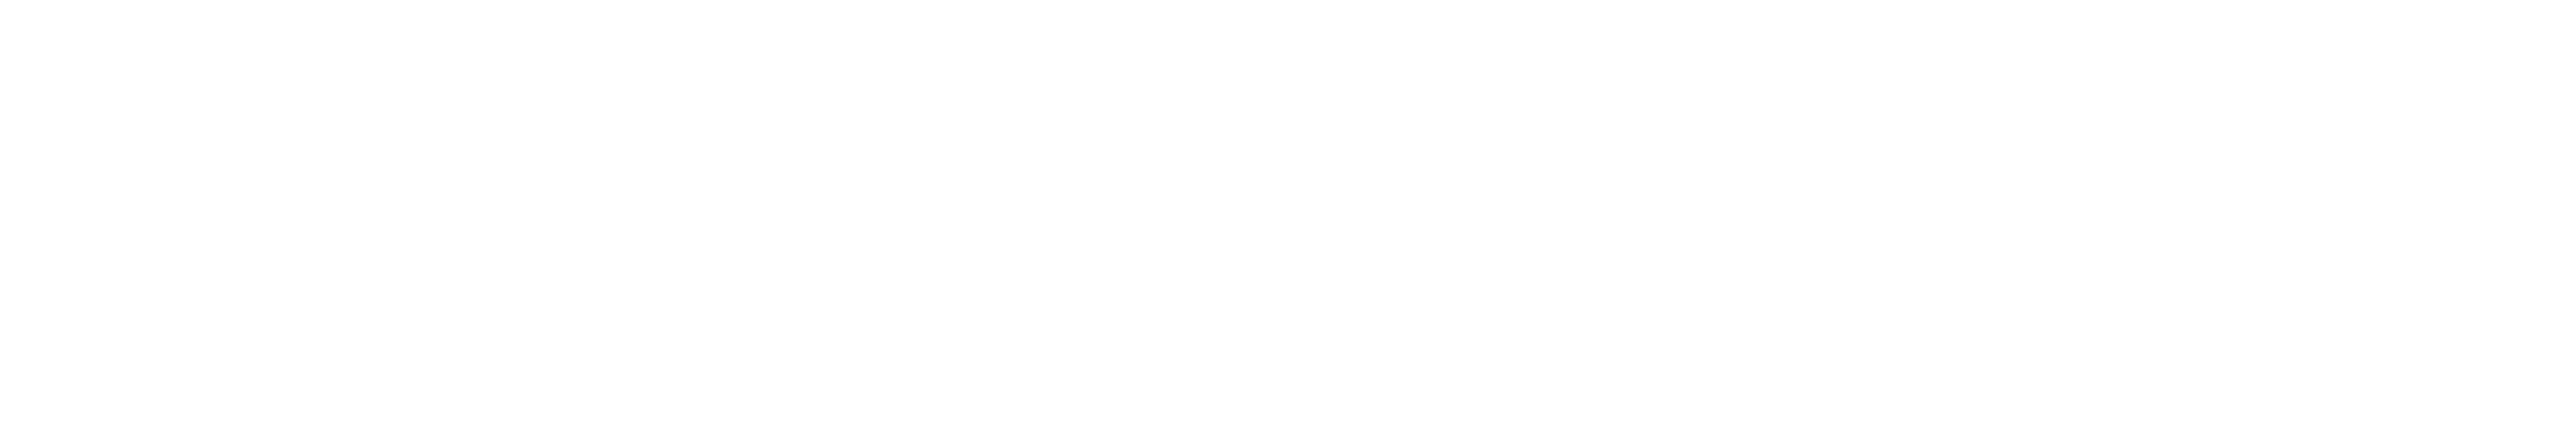

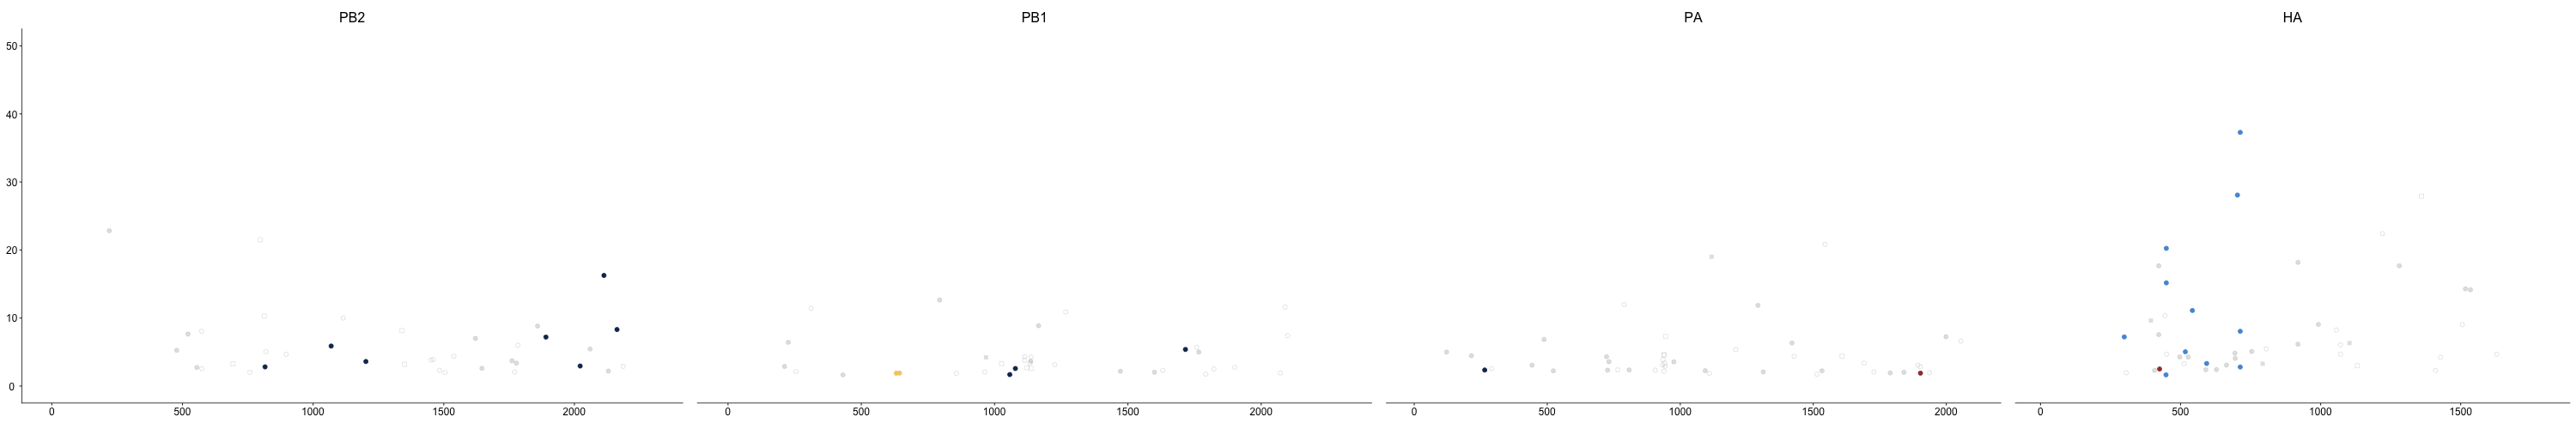

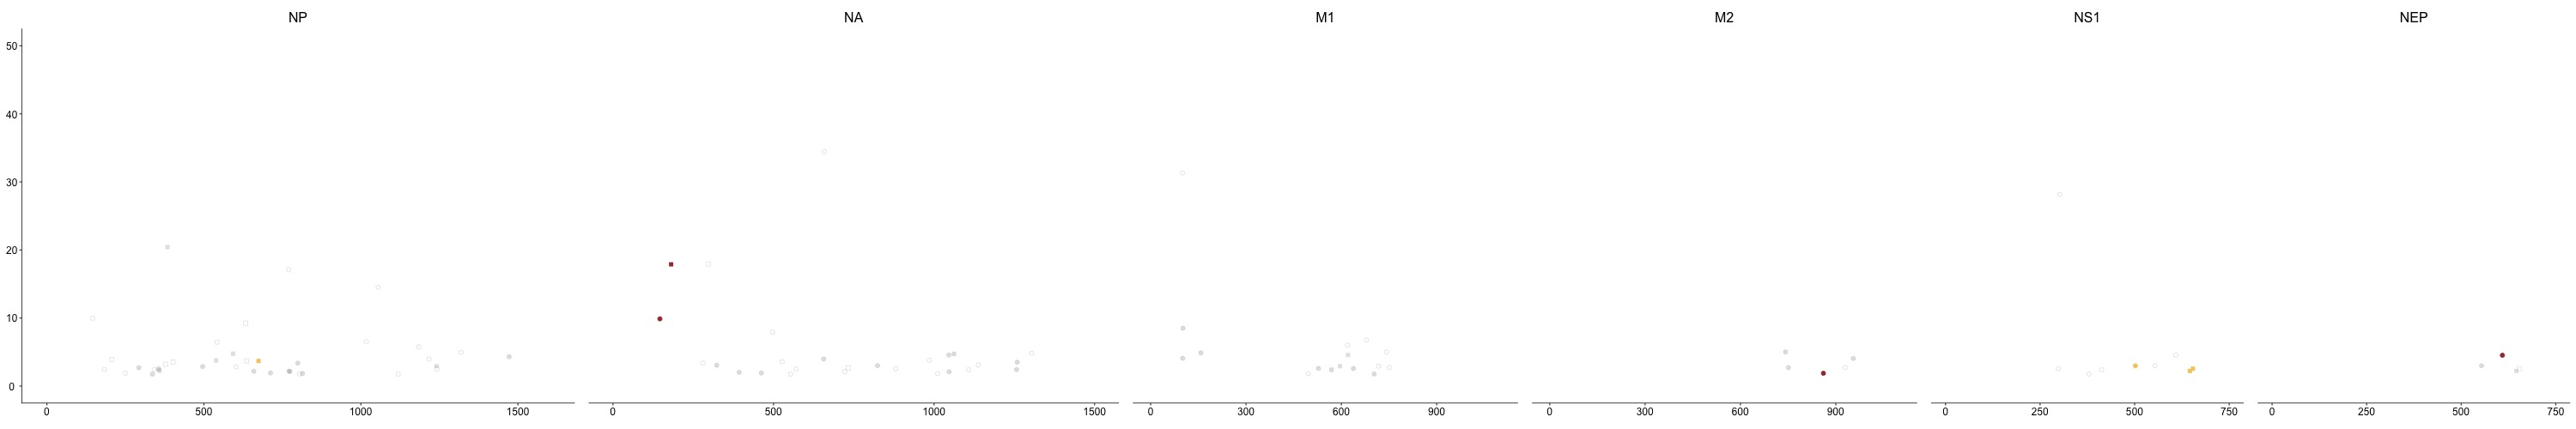

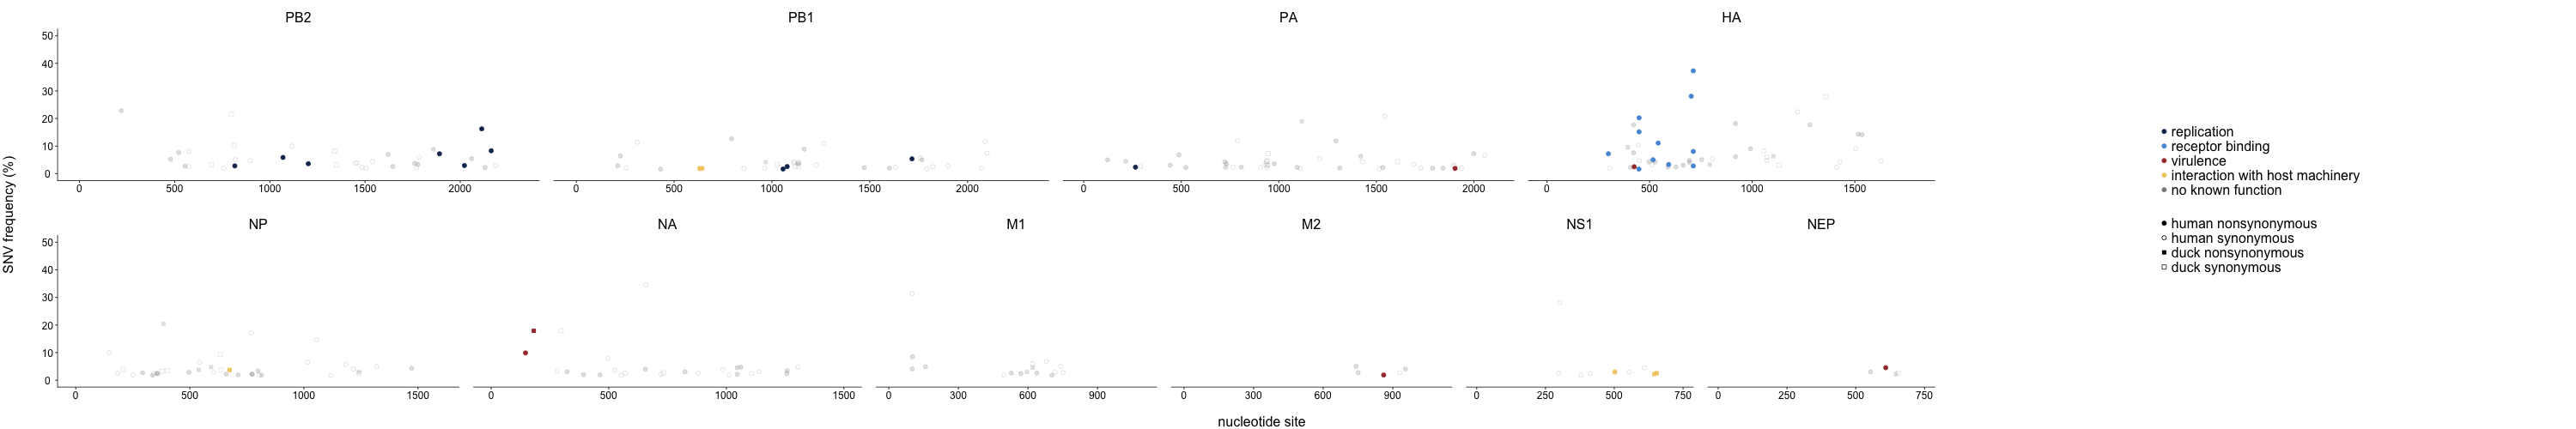

In [31]:
%%R -w 3000 -h 500 -u px -i typed2  # this sets the size of the plot...otherwise, it will go off the page"

require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)
        
typed2$gene = gsub("neuraminidase", "NA", typed2$gene)
typed2$genef = factor(typed2$gene, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))
typed2$typef = factor(typed2$type, levels=c("replication","receptor binding","virulence", "interaction with host machinery","no known function"))
typed2$species_nsf = factor(typed2$species_ns, levels=c("human nonsynonymous", "human synonymous", "duck nonsynonymous","duck synonymous"))

blank_data <- data.frame(genef = c("PB2","PB2","PB1","PB1","PA","PA","HA","HA","NP","NP","NA","NA","M1","M1","M2","M2","NS1","NS1","NEP","NEP"), x = c(0,2500,0,2500,0,2500,0,1800,0,1600,0,1500,0,1200,0,1200,0,1000,0,1000), y = 0, synonymous_nonsynonymous="nonsynonymous",typef="no known function",species='duck', species_nsf='duck nonsynonymous')

genes = c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP')
stops = list('PB2'=2300,'PB1'=2300,'PA'=2100,'HA'=1800,'NP'=1600,'NA'=1500,'M1'=1100,'M2'=1100,'NS1'=750,'NEP'=750)
steps = list('PB2'=500,'PB1'=500,'PA'=500,'HA'=500,'NP'=500,'NA'=500,'M1'=300,'M2'=300,'NS1'=250,'NEP'=250)
plots = list()

for (g in genes)
{
    df = typed2[typed2$gene == g,]
    stop = stops[[g]]
    step = steps[[g]]
    name = paste(g, "plot",sep = '_')
    
    # set PB2 and NP-specific y-axis aesthetics
    if (g == "PB2"| g == 'NP'){
        y_aesthetics = theme(axis.line.y=element_line(colour="black"))+
        theme(axis.text.y=element_text(hjust=0.5))            
    } else {
        y_aesthetics = theme(axis.line.y=element_blank())+
        theme(axis.ticks.y= element_blank())+
        theme(axis.text.y=element_blank())
    }
        
    p <- ggplot(data=df, aes(x=reference_position, y=frequency*100, color=typef, alpha=typef, shape=species_nsf)) + #, alpha=host_specific
        geom_point(size=2)+                                                  
        geom_blank(data = blank_data, aes(x = x, y = y))+
        theme(panel.grid.major=element_line(colour=NA,size=NA))+
        theme(panel.grid.minor=element_line(colour=NA,size=NA))+
        theme(plot.title=element_text(size=16, hjust=0.5))+
        theme(strip.background = element_rect(colour=NA, fill=NA))+
        theme(plot.margin=unit(c(0.5,0.25,0.5,0.25),"cm"))+    # this sets the plot margins as top, left, bottom, right
        theme(axis.line.x=element_line(colour="black"))+
        theme(strip.text.x=element_text(size=13))+
        theme(axis.title.y=element_blank())+#text(size=16, hjust=0.5, vjust=0.5))+
        theme(axis.title.x=element_blank())+#text(size=16, vjust=0.5))+
        theme(axis.text=element_text(size=12, colour="black"))+
        y_aesthetics+
        scale_color_manual(values=c("replication"="#14325C","receptor binding"="#5398D9","virulence"="#A53A3B", "interaction with host machinery"="#F4CC70","no known function"="#8A8A89"), guide=FALSE)+
        scale_shape_manual(values=c("human nonsynonymous"=19,"human synonymous"=1,"duck nonsynonymous"=15,"duck synonymous"=0), guide=FALSE)+
        scale_alpha_manual(values=c("replication"=1,"receptor binding"=1,"virulence"=1, "interaction with host machinery"=1,"no known function"=0.25), guide=FALSE)+
        theme(legend.text=element_text(size=16))+
        theme(legend.title=element_blank())+
        theme(panel.margin=unit(1, "lines"))+
        theme(panel.background=element_rect(fill=NA, color=NA))+
        theme(legend.key=element_rect(fill=NA))+
        theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
        labs(x="\nnucleotide site",y="SNV frequency\n", title=g)+
        theme(legend.direction = 'horizontal', legend.position = 'right')+
        scale_y_continuous(limits=c(0,50))+
        scale_x_continuous(limits=c(0,stop), breaks=seq(0,stop,step))
    
    plots[[name]] <- p
} 

# add in an extra, blank plot with a legend so that I can plot the legend in a separate panel 
extra <- ggplot(data=typed2, aes(x=reference_position, y=frequency, color=typef, shape=species_nsf))+
    geom_point(size=2)+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
    scale_color_manual(values=c("replication"="#14325C","receptor binding"="#5398D9","virulence"="#A53A3B", "interaction with host machinery"="#F4CC70","no known function"="#8A8A89"), breaks=c("replication","receptor binding","virulence", "interaction with host machinery","no known function"), drop=FALSE)+
    scale_shape_manual(values=c(19,1,15,0), breaks=c("human nonsynonymous", "human synonymous", "duck nonsynonymous","duck synonymous"), drop=FALSE)+
    guides(color = guide_legend(nrow = 5))+
    guides(shape = guide_legend(nrow = 5))

# extract out the legend and then plot just that 
gglegend <- function(x){ 
  tmp <- ggplot_gtable(ggplot_build(x)) 
  leg <- which(sapply(tmp$grobs, function(y) y$name) == "guide-box") 
  tmp$grobs[[leg]]
}

leg = gglegend(extra)
                      
top <- grid.arrange(plots[[1]],plots[[2]],plots[[3]],plots[[4]],ncol=4, widths=c(0.23,0.23,0.21,0.19))
bottom <- grid.arrange(plots[[5]],plots[[6]],plots[[7]],plots[[8]],plots[[9]],plots[[10]], ncol=6, widths=c(0.16,0.15,0.11,0.11,0.09,0.09))

# set up the layout for the overall plot
lay <- rbind(c(1,1,1,3),
             c(2,2,2,3))
p <- grid.arrange(top, bottom, leg, layout_matrix = lay, left = textGrob("SNV frequency (%)\n", gp=gpar(fontsize=16), rot=90), bottom=textGrob("nucleotide site", hjust = 1, gp=gpar(fontsize=16)))

ggsave("Fig-2-SNPs-annotated-2019-06-04.pdf", p, width = 14, height = 5, useDingbats=FALSE, path="/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-06-04/individual-PDFs")

## Output data to format to generate Table 3

In [36]:
# write out only sites that are annotated as potentially important for host switching
df2 = df[df['host_specific'] == 'yes']
df2.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species
9,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PB2,A/duck/Cambodia/381W11M4/2013,PB2,1350,C,T,Asp441Asp,synonymous,3.19%,0.0319,Influenza A_PB2_cap-binding-site_320(164),This fragment is a domain co-crystalized with ...,yes,duck
17,AJJ9KL707F513_A_duck_Cambodia_083D1_2011_N1,A/duck/Cambodia/083D1/2011,neuraminidase,181,A,G,Lys58Glu,nonsynonymous,17.89%,0.1789,Influenza A_N1_determinant-of-host-range-speci...,The length of the NA stalk affects the host ra...,yes,duck
24,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,A/duck/Cambodia/Y0224301/2014,NS1,646,T,C,Leu207Pro,nonsynonymous,2.22%,0.0222,Influenza A_NS1_flexible-tail_204(27),The flexible tail appears to be unstructured a...,yes,duck
26,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,A/duck/Cambodia/Y0224301/2014,NS1,654,C,T,Pro210Ser,nonsynonymous,2.55%,0.0255,Influenza A_NS1_flexible-tail_204(27),The flexible tail appears to be unstructured a...,yes,duck
36,AH7E5L724F516_A_duck_Cambodia_Y0224304_2014_NP,A/duck/Cambodia/Y0224304/2014,NP,633,C,T,Ile201Ile,synonymous,9.23%,0.0923,Influenza A_NP_nuclear-localization-signal2_19...,This region is a nuclear targeting motif that ...,yes,duck


In [37]:
# write out to csv
df2.to_csv("/Users/lmoncla/Documents/H5N1_Cambodian_outbreak_study/paper-and-figure-drafts/figures-2019-06-04/snps-at-known-sites-2019-06-04.txt", sep='\t')